### Etapa 1: Extração

**Objetivo:**
Extrair os dados da API aberta do Mercado Livre

**Documentação:**
- https://developers.mercadolivre.com.br/pt_br/itens-e-buscas
- https://developers.mercadolivre.com.br/pt_br/consideracoes-de-design

**Requisito I:**
- Editar a variável `ITEM_NAME` altera a extração

**Observações sobre a etapa:**
- As requisições gratuitas são limitadas a 1000 itens
- Algumas páginas retornam um valor menor de itens
- Utilizei variáveis globais aqui por simplicidade, mas o ideal seria encapsular as varíaveis em classes

In [1]:
import json
import requests
import time

# Params
BASE_URL = "https://api.mercadolibre.com/"
SITE = "MLB"
ITEM_NAME = "cofre"

# Metrics
ITEM_COUNT = 0
ITEM_TOTAL = 0
REQUEST_COUNT = 0
REQUEST_TOTAL_TIME = 0

# Request (only GET) and monitor (count and time spent)
def request_monitor(url):
    # Request time spent
    request_start = time.time()
    response = requests.get(url)
    request_end = time.time()
    global REQUEST_TOTAL_TIME
    REQUEST_TOTAL_TIME += (request_end - request_start)
    
    # Request count
    global REQUEST_COUNT
    REQUEST_COUNT += 1

    return response


# Returns total number of items
def get_item_quantity(site, item_name):
    
    url = f"{BASE_URL}sites/{site}/search?q={item_name}"
    
    # Request and Monitor
    response = request_monitor(url)
    
    if response.status_code == 200:
        total = response.json().get("paging").get("total")
        return total
    else:
        print(f"Failed to check number of items: {response.status_code} \n {response.json()}")
        return None


def search_item_name(site, item_name, offset, max_offset, limit):
    raw_data = []
    while offset <= max_offset:
        url = f"{BASE_URL}sites/{site}/search?q={item_name}&offset={offset}&limit={limit}#json"
        response = request_monitor(url)
        if response.status_code == 200:
            response_dict = response.json()
            global ITEM_COUNT
            ITEM_COUNT += len(response_dict.get("results"))
            raw_data.append(response.json())
            offset += limit
            print(f'Fetched page {int(offset / limit)}: {len(response_dict.get("results"))} items')
        else:
            raise Exception(f"{response.status_code} | Failed to fetch offset {offset}: \n {response.json()}")
    return raw_data


def main_extraction():
    # Pagination params
    offset = 0
    max_offset = 950 # max allowed for free users is 1000 items
    limit = 50

    # Item search
    raw_data = search_item_name(site=SITE, item_name=ITEM_NAME, offset=offset, max_offset=max_offset, limit=limit)

    global ITEM_TOTAL
    ITEM_TOTAL = get_item_quantity(site=SITE, item_name=ITEM_NAME)

    print(f"Fetched {len(raw_data)} pages: {ITEM_COUNT} of {ITEM_TOTAL} items")
    print(
        f"""\nRequests made: {REQUEST_COUNT}\nRequests total time (s): {REQUEST_TOTAL_TIME}\nAverage time per request (s): {REQUEST_TOTAL_TIME / REQUEST_COUNT}""")
    return raw_data

RAW_DATA = main_extraction()


Fetched page 1: 50 items
Fetched page 2: 50 items
Fetched page 3: 50 items
Fetched page 4: 50 items
Fetched page 5: 50 items
Fetched page 6: 49 items
Fetched page 7: 50 items
Fetched page 8: 50 items
Fetched page 9: 50 items
Fetched page 10: 49 items
Fetched page 11: 49 items
Fetched page 12: 50 items
Fetched page 13: 50 items
Fetched page 14: 50 items
Fetched page 15: 50 items
Fetched page 16: 50 items
Fetched page 17: 50 items
Fetched page 18: 50 items
Fetched page 19: 50 items
Fetched page 20: 49 items
Fetched 20 pages: 996 of 12415 items

Requests made: 21
Requests total time (s): 10.534012794494629
Average time per request (s): 0.5016196568806967


### Etapa 2: Reestruturação dos dados

**Objetivo:**
A partir dos dados brutos estruturá-los para análise

**Observações sobre a etapa:**
- A ideia é criar uma estrutura paginada, assim é possível analisar o que aparece mais nas primeiras páginas, por exemplo
- Aqui poderíamos também modelar, validar e tipar os dados, porém não fiz pois acredito que não convém

In [2]:
import pandas as pd

def flatten_data(data):
    # Flatten the dictionary
    flat_data = []
    for page, records in data.items():
        for record in records:
            record['page'] = page
            flat_data.append(record)

    return pd.DataFrame(flat_data)


def main_structure():
    page_results = {}
    results = []
    n_page = 1
    for page in RAW_DATA:
        page_results[n_page] = page.get('results')
        n_page += 1

    flat_data = flatten_data(page_results)

    return flat_data 

flat_page_df = main_structure()

### Etapa 3: Análise exploratória

**Objetivo:**
Analisar os dados de forma a responder as seguintes perguntas:
- Quantos e quem são os vendedores?
- Quais são os vendedores com mais de 10 anúncios?
- Qual a média de preço dos itens no geral e por página?
- Quantos itens possuem entrega grátis nor geral e por página?

**Requisito II**

**Observações sobre a etapa (amostra de dados):**
- Por trás dos 996 anúncios estão 391 vendedores
- Apenas 17 vendedores possuem mais de 10 anúncios
- As primeiras páginas (1 a 5) aparentam mostrar anúncios com preços menores
- A maior parte dos anúncios registra disponibilidade de entrega grátis. Logo é possível inferir que a disponibilidade de entrega grátis não afeta a ordem dos itens

#### Iniciar aqui

#### Quantos e quem são os vendedores?

In [3]:
# Add seller nickname to df
flat_page_df['seller_nickname'] = flat_page_df['seller'].apply(lambda x: x['nickname'])

# Number of unique sellers
num_sellers = flat_page_df['seller_nickname'].nunique()
sellers_df = flat_page_df[['seller_nickname']].drop_duplicates().reset_index(drop=True)

# Display results
print(f"Número de vendedores: {num_sellers}")
sellers_df

Número de vendedores: 394


,seller_nickname
0,CLASP STORE
1,VERONA SHOP
2,NEBRASKA PARTS
3,MAIKO_BRASIL
4,FLYSEA
...,...
389,HERNANDESKARINA20220323170755
390,SHOPERBRASIL.COM.BR
391,MAPAROSA3
392,LOJAS BOM


#### Quais são os vendedores com mais de 10 anúncios?

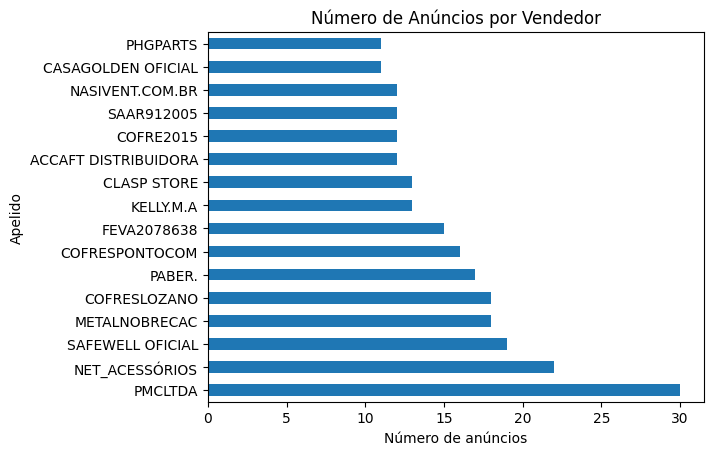

In [4]:
import matplotlib.pyplot as plt

# Number of listings per seller
listings_per_seller = flat_page_df['seller_nickname'].value_counts()

# Filter sellers with more than one listing
filtered_listings_per_seller = listings_per_seller[listings_per_seller > 10]

# Plotting number of listings per seller
filtered_listings_per_seller.plot(kind='barh', title='Número de Anúncios por Vendedor', ylabel='Apelido', xlabel='Número de anúncios')

plt.show()

#### Qual a média de preço dos itens no geral e por página?

Média de preço: 457.6648694779117


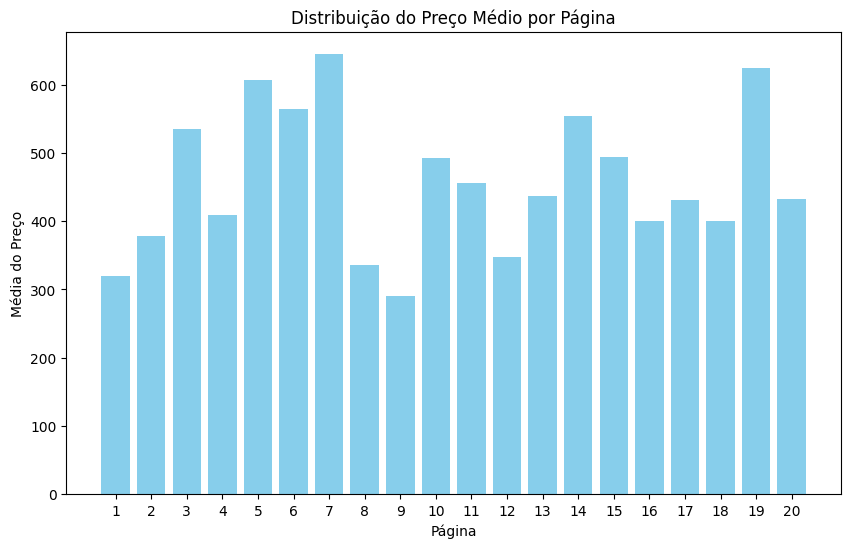

In [5]:

# Calculate the average price 
average_price = flat_page_df['price'].mean()
print(f"Média de preço: {average_price}")

# Calculate the average price per page
average_price_per_page = flat_page_df.groupby('page')['price'].mean().reset_index()

# Rename the columns for clarity
average_price_per_page.columns = ['page', 'average_price']

## Plotting the distribution
plt.figure(figsize=(10, 6))
plt.bar(average_price_per_page['page'], average_price_per_page['average_price'], color='skyblue')
plt.xlabel('Página')
plt.ylabel('Média do Preço')
plt.title('Distribuição do Preço Médio por Página')
plt.xticks(average_price_per_page['page'])
plt.show()

#### Quantos itens possuem entrega grátis nor geral e por página?

Itens com entrega grátis disponível: 748


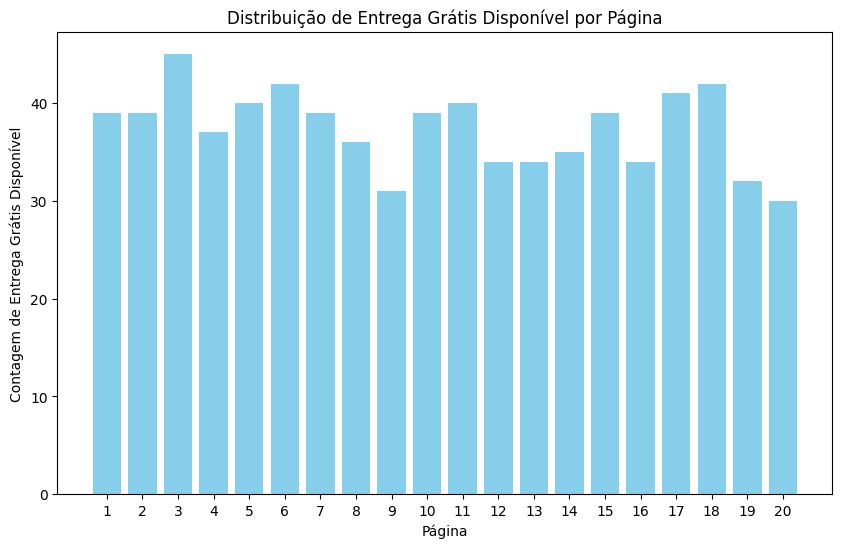

In [6]:
# Count free shipping per record
flat_page_df['free_shipping'] = flat_page_df['shipping'].apply(lambda x: x.get('free_shipping', False))

# Count free shipping
free_shipping_count = flat_page_df['free_shipping'].sum()
print(f"Itens com entrega grátis disponível: {free_shipping_count}")

# Sum free shipping counts per page
free_shipping_per_page = flat_page_df.groupby('page')['free_shipping'].sum().reset_index()

# Rename the columns for clarity
free_shipping_per_page.columns = ['page', 'free_shipping_count']

## Plotting the distribution
plt.figure(figsize=(10, 6))
plt.bar(free_shipping_per_page['page'], free_shipping_per_page['free_shipping_count'], color='skyblue')
plt.xlabel('Página')
plt.ylabel('Contagem de Entrega Grátis Disponível')
plt.title('Distribuição de Entrega Grátis Disponível por Página')
plt.xticks(free_shipping_per_page['page'])
plt.show()